In [5]:
# import data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
def divide_img(im):
    out=[]
    im.mode = 'I'
    im = im.point(lambda i:i*(1./256)).convert('L')
    h = int(im.size[1]/3)
    w = im.size[0]
    pad=int(w*0.1)
    for i in range(3):
        upper=i*h
        box = (0,upper, w,upper + h)
        tmp = im.crop(box)
        img = tmp.crop((pad,pad,tmp.size[0]-pad,tmp.size[1]-pad))
        out.append(img)
    return out

In [7]:
def merge(im1, im2, w, h, padding=300):
    width = im1.size[0] + padding
    height =im1.size[1] + padding
    im = Image.new('L', (width, height), (255))
    im.paste(im2, (padding//2+w, padding//2+h))

    return im

In [8]:
import scipy.ndimage as ndimage
def preprocess(img):
    smooth = ndimage.gaussian_filter(img, sigma=2)
    out = np.multiply(img, 2)-smooth
    out = img-smooth
    return Image.fromarray(out)

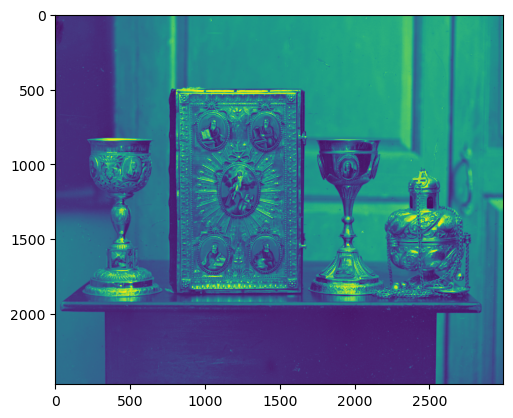

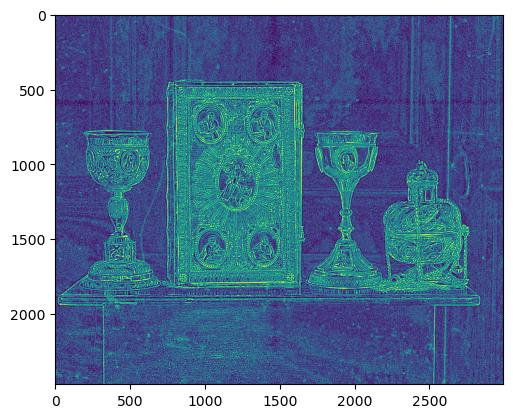

In [9]:
# name = "00125v" 
# name = "00149v" 
# name = "00153v" # base2
# name = "00351v" 
# name = "00398v" 
# name = "01112v" 
name = "01047u" 
# name = "01657u" 
# name = "01861a" 

# im=Image.open("data/{}.jpg".format(name)) 

im=Image.open("data_hires/{}.tif".format(name)) 

# seperate image into three layers
imgs_basic=divide_img(im)

# img preprocess: Laplacian of Gaussian filter
plt.imshow(imgs_basic[1])
imgs_preprocess = []
for i, img in enumerate(imgs_basic):
    imgs_preprocess.append(preprocess(img)) 
plt.figure()
plt.imshow(imgs_preprocess[2])

25 20
71 33


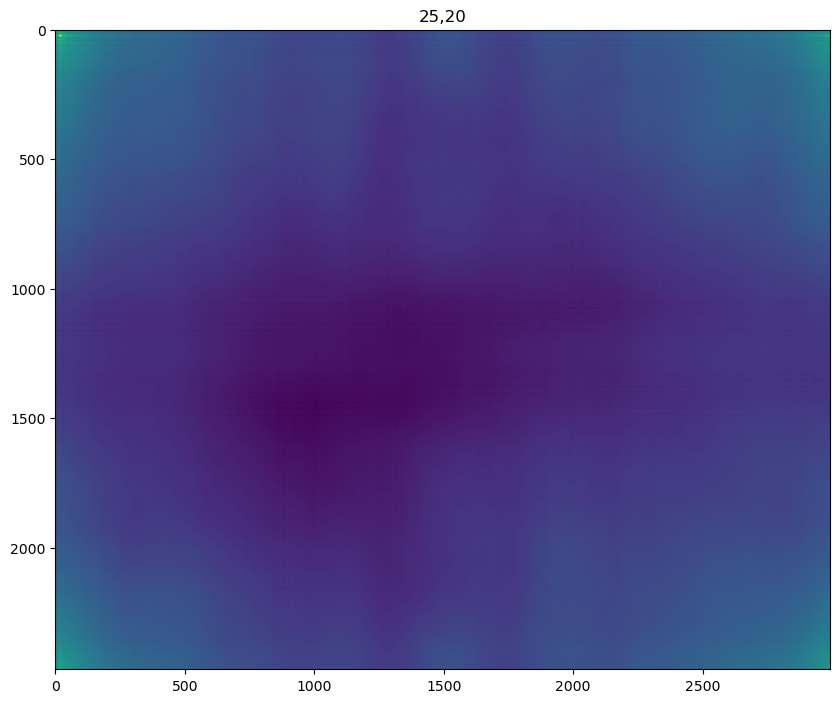

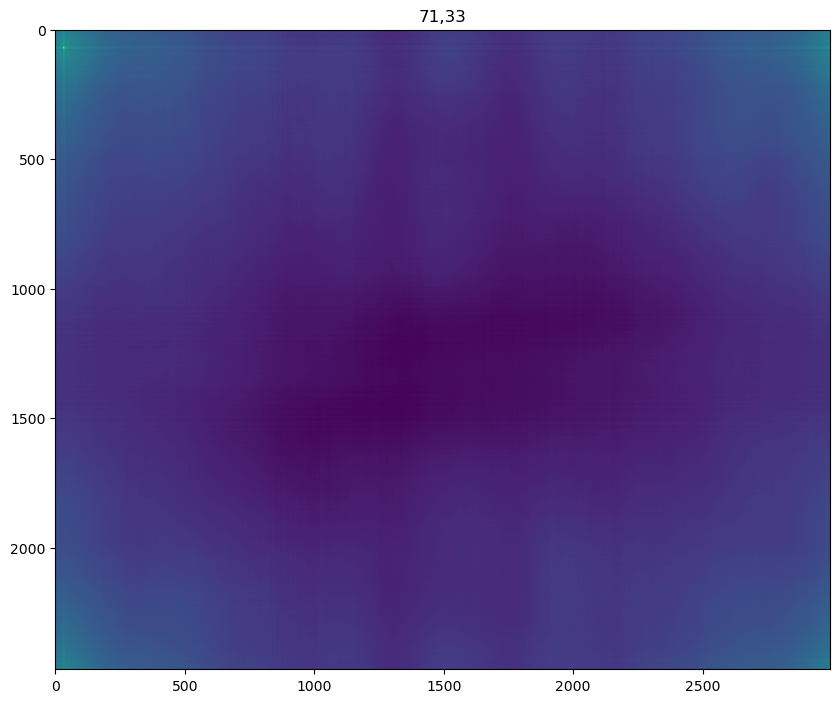

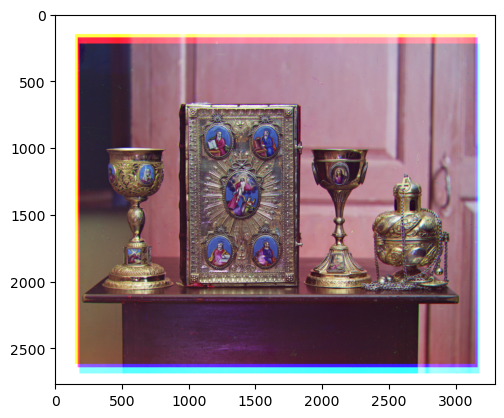

In [10]:
from numpy import unravel_index
import time

# start_time = time.time()

baseIdx = 0
base = imgs_basic[baseIdx]
imgs = [img for i,img in enumerate(imgs_basic) if i!= baseIdx]

base_sh = imgs_preprocess[baseIdx]
imgs_sh = [img for i,img in enumerate(imgs_preprocess) if i!= baseIdx]
out_l = []
out_l.append(merge(base,base,0,0))

for i,img in enumerate(imgs):
    b0_fft = np.fft.fft2(base_sh)
    b1_fft = np.fft.fft2(imgs_sh[i])
    b1_conj = np.conjugate(b1_fft)
    prod = np.multiply(b0_fft, b1_conj)
    ifft = np.fft.ifft2(prod)
    h,w = unravel_index(ifft.argmax(), ifft.shape)
    print(h,w)
    out_l.append(merge(base,img,w,h))
    plt.figure(figsize=(10,10))
    # plt.figure()
    dis = "{},{}".format(h,w)
    plt.title(dis)
    plt.imshow(ifft.real)
    # plt.savefig("output/preprocess/{}_{}".format(name, dis))

# im_out = Image.merge('RGB', (out_l[0], out_l[2], out_l[1]))
im_out = Image.merge('RGB', (out_l[2], out_l[1], out_l[0]))

# end_time = time.time()
# total_time = end_time-start_time
# print("Fourier-based alignment runtime: ", total_time)

plt.figure()
plt.imshow(im_out)
title = "w_preprocess_{}".format(name)
# im_out.save("output/preprocess/{}.jpg".format(title))